In [1]:
import emoji
import pandas as pd
import numpy as np

In [2]:
emoji_dict = {      "0": "\u2764\uFE0F",    
                    "1": ":baseball:",
                    "2": ":beaming_face_with_smiling_eyes:",
                    "3": ":downcast_face_with_sweat:",
                    "4": ":fork_and_knife:",
                   }

In [3]:
for e in emoji_dict.values():
    print(emoji.emojize(e))

❤️
⚾
😁
😓
🍴


In [4]:
fullData = pd.read_csv("Data_Copy/train_emoji.csv", header=None)

In [5]:
fullData.head()

,0,1
0,never talk to me again,3
1,I am proud of your achievements,2
2,It is the worst day in my life,3
3,Miss you so much,3
4,food is life,4


In [6]:
TextData=fullData[0].values
LabelData=fullData[1].values

In [7]:
TextData[0]

'never talk to me again'

In [8]:
LabelData[:5]

array([3, 2, 3, 3, 4], dtype=int64)

In [9]:
# for sent,label in zip(TextData,LabelData):
#     print(sent,label)
#     print(emoji.emojize(emoji_dict[str(label)]))

In [10]:
TextData.shape

(135,)

In [11]:
LabelData.shape

(135,)

# Word Embeddings

In [12]:
file = open("glove.6B.300d.txt", encoding='utf8')

In [13]:
embedding_index = {}
for line in file:
    
    values = line.split()
    word = values[0]
    embedValues = np.array(values[1:], dtype='float')
    
    embedding_index[word] = embedValues

In [14]:
# embedding_index['not']

In [15]:
embedding_index['not'].shape

(300,)

In [16]:
# len(embedding_index)

In [17]:
def get_embedding_output(X):
    vocab_size=0
    maxLen = 10
    embedding_output = np.zeros((len(X), maxLen, 300))
    
    for ix in range(len(X)):
        X[ix] = X[ix].split()
        
        for ij in range(len(X[ix])):
            embedding_output[ix][ij] = embedding_index[X[ix][ij].lower()]
            vocab_size = vocab_size+1
    return embedding_output,vocab_size

In [18]:
def get_embedding_for_testing(X):
    file = open("glove.6B.300d.txt", encoding='utf8')
    embedding_index = {}
    for line in file:

        values = line.split()
        word = values[0]
        embedValues = np.array(values[1:], dtype='float')

        embedding_index[word] = embedValues
    maxLen = 10
    embedding_output = np.zeros((len(X), maxLen, 300))
    
    for ix in range(len(X)):
        X[ix] = X[ix].split()
        
        for ij in range(len(X[ix])):
            embedding_output[ix][ij] = embedding_index[X[ix][ij].lower()]
    return embedding_output

In [19]:
TextDataEmbeddings,vocab_size = get_embedding_output(TextData)
print(vocab_size)

639


In [20]:
TextDataEmbeddings.shape

(135, 10, 300)

In [21]:
from keras.utils import to_categorical

LabelData = to_categorical(LabelData)

In [22]:
LabelData.shape

(135, 5)

# Model Building

In [23]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, SimpleRNN,Embedding
from keras.layers import Bidirectional, LeakyReLU

In [52]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64, return_sequences= True )))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(units = 64)))
model.add(Dropout(0.5))

# model.add(Dense(units= 64))
# model.add(LeakyReLU(alpha=0.05))

model.add(Dense(units= 10, activation='tanh'))

model.add(Dense(units= 5, activation= 'softmax'))

In [53]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

In [54]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("bilstm_model.h5", monitor='loss', verbose=1, save_best_only=True)
k = 7
kf = KFold(n_splits=k)
acc_scores = []
for train_index, test_index in kf.split(TextDataEmbeddings):
    X_train, X_test = TextDataEmbeddings[train_index], TextDataEmbeddings[test_index]
    Y_train, Y_test = LabelData[train_index], LabelData[test_index]
    
    
    #run the model for every fold
    model.fit(X_train, Y_train , shuffle=True, batch_size=64, epochs=50,callbacks=[checkpoint])
    score, acc = model.evaluate(X_test, Y_test, verbose=0)
    acc_scores.append(acc)
    print('Validation accuracy:', acc)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 1.6089 - accuracy: 0.2435 
Epoch 1: loss improved from inf to 1.60894, saving model to bilstm_model.h5
2/2 [==============================] - 10s 111ms/step - loss: 1.6089 - accuracy: 0.2435
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 1.5281 - accuracy: 0.3594
Epoch 2: loss improved from 1.60894 to 1.52302, saving model to bilstm_model.h5
2/2 [==============================] - 0s 90ms/step - loss: 1.5230 - accuracy: 0.3391
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 1.4933 - accuracy: 0.2812
Epoch 3: loss improved from 1.52302 to 1.48482, saving model to bilstm_model.h5
2/2 [==============================] - 0s 84ms/step - loss: 1.4848 - accuracy: 0.2870
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.3391
Epoch 4: loss improved from 1.48482 to 1.41067, saving model to bilstm_model.h5
2/2 [==============================] - 0s 143ms/step - 

Epoch 33/50
1/2 [==============>...............] - ETA: 0s - loss: 0.3281 - accuracy: 0.9688
Epoch 33: loss did not improve from 0.31694
2/2 [==============================] - 0s 42ms/step - loss: 0.3189 - accuracy: 0.9826
Epoch 34/50
1/2 [==============>...............] - ETA: 0s - loss: 0.2809 - accuracy: 0.9844
Epoch 34: loss improved from 0.31694 to 0.28854, saving model to bilstm_model.h5
2/2 [==============================] - 0s 82ms/step - loss: 0.2885 - accuracy: 0.9913
Epoch 35/50
1/2 [==============>...............] - ETA: 0s - loss: 0.2872 - accuracy: 1.0000
Epoch 35: loss improved from 0.28854 to 0.27900, saving model to bilstm_model.h5
2/2 [==============================] - 0s 95ms/step - loss: 0.2790 - accuracy: 1.0000
Epoch 36/50
1/2 [==============>...............] - ETA: 0s - loss: 0.2638 - accuracy: 1.0000
Epoch 36: loss improved from 0.27900 to 0.27364, saving model to bilstm_model.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.2736 - accuracy: 0.99

1/2 [==============>...............] - ETA: 0s - loss: 0.1319 - accuracy: 1.0000
Epoch 16: loss improved from 0.15570 to 0.14802, saving model to bilstm_model.h5
2/2 [==============================] - 0s 103ms/step - loss: 0.1480 - accuracy: 0.9913
Epoch 17/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1678 - accuracy: 0.9844
Epoch 17: loss improved from 0.14802 to 0.14488, saving model to bilstm_model.h5
2/2 [==============================] - 0s 104ms/step - loss: 0.1449 - accuracy: 0.9913
Epoch 18/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1460 - accuracy: 0.9844
Epoch 18: loss improved from 0.14488 to 0.14184, saving model to bilstm_model.h5
2/2 [==============================] - 0s 103ms/step - loss: 0.1418 - accuracy: 0.9913
Epoch 19/50
1/2 [==============>...............] - ETA: 0s - loss: 0.1230 - accuracy: 1.0000
Epoch 19: loss improved from 0.14184 to 0.14076, saving model to bilstm_model.h5
2/2 [==============================] - 0s 105ms/step - 

2/2 [==============================] - 0s 107ms/step - loss: 0.0783 - accuracy: 1.0000
Epoch 48/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0709 - accuracy: 1.0000
Epoch 48: loss improved from 0.07828 to 0.07730, saving model to bilstm_model.h5
2/2 [==============================] - 0s 88ms/step - loss: 0.0773 - accuracy: 1.0000
Epoch 49/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0690 - accuracy: 1.0000
Epoch 49: loss improved from 0.07730 to 0.07590, saving model to bilstm_model.h5
2/2 [==============================] - 0s 88ms/step - loss: 0.0759 - accuracy: 1.0000
Epoch 50/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0845 - accuracy: 1.0000
Epoch 50: loss did not improve from 0.07590
2/2 [==============================] - 0s 38ms/step - loss: 0.0762 - accuracy: 1.0000
Validation accuracy: 1.0
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 1.0000
Epoch 1: loss did not improve from 0.07590
2/2 [=====

2/2 [==============================] - 0s 84ms/step - loss: 0.0513 - accuracy: 1.0000
Epoch 31/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0570 - accuracy: 1.0000
Epoch 31: loss improved from 0.05134 to 0.05132, saving model to bilstm_model.h5
2/2 [==============================] - 0s 85ms/step - loss: 0.0513 - accuracy: 1.0000
Epoch 32/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0490 - accuracy: 1.0000
Epoch 32: loss improved from 0.05132 to 0.05039, saving model to bilstm_model.h5
2/2 [==============================] - 0s 82ms/step - loss: 0.0504 - accuracy: 1.0000
Epoch 33/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0526 - accuracy: 1.0000
Epoch 33: loss improved from 0.05039 to 0.04954, saving model to bilstm_model.h5
2/2 [==============================] - 0s 86ms/step - loss: 0.0495 - accuracy: 1.0000
Epoch 34/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000
Epoch 34: loss improved from 0.04954 to 0

Epoch 13/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0392 - accuracy: 1.0000
Epoch 13: loss improved from 0.03709 to 0.03666, saving model to bilstm_model.h5
2/2 [==============================] - 0s 82ms/step - loss: 0.0367 - accuracy: 1.0000
Epoch 14/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0391 - accuracy: 1.0000
Epoch 14: loss improved from 0.03666 to 0.03632, saving model to bilstm_model.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.0363 - accuracy: 1.0000
Epoch 15/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0373 - accuracy: 1.0000
Epoch 15: loss improved from 0.03632 to 0.03614, saving model to bilstm_model.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.0361 - accuracy: 1.0000
Epoch 16/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0361 - accuracy: 1.0000
Epoch 16: loss improved from 0.03614 to 0.03576, saving model to bilstm_model.h5
2/2 [==============================] - 0s 82ms

Epoch 45/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0295 - accuracy: 1.0000
Epoch 45: loss improved from 0.02882 to 0.02866, saving model to bilstm_model.h5
2/2 [==============================] - 0s 96ms/step - loss: 0.0287 - accuracy: 1.0000
Epoch 46/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0318 - accuracy: 1.0000
Epoch 46: loss did not improve from 0.02866
2/2 [==============================] - 0s 39ms/step - loss: 0.0288 - accuracy: 1.0000
Epoch 47/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0293 - accuracy: 1.0000
Epoch 47: loss improved from 0.02866 to 0.02831, saving model to bilstm_model.h5
2/2 [==============================] - 0s 86ms/step - loss: 0.0283 - accuracy: 1.0000
Epoch 48/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0275 - accuracy: 1.0000
Epoch 48: loss improved from 0.02831 to 0.02793, saving model to bilstm_model.h5
2/2 [==============================] - 0s 86ms/step - loss: 0.0279 - accuracy: 1.00

Epoch 28/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0240 - accuracy: 1.0000
Epoch 28: loss improved from 0.02344 to 0.02327, saving model to bilstm_model.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.0233 - accuracy: 1.0000
Epoch 29/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0236 - accuracy: 1.0000
Epoch 29: loss improved from 0.02327 to 0.02322, saving model to bilstm_model.h5
2/2 [==============================] - 0s 90ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 30/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0251 - accuracy: 1.0000
Epoch 30: loss improved from 0.02322 to 0.02319, saving model to bilstm_model.h5
2/2 [==============================] - 0s 84ms/step - loss: 0.0232 - accuracy: 1.0000
Epoch 31/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0239 - accuracy: 1.0000
Epoch 31: loss improved from 0.02319 to 0.02310, saving model to bilstm_model.h5
2/2 [==============================] - 0s 84ms

2/2 [==============================] - 0s 84ms/step - loss: 0.0188 - accuracy: 1.0000
Epoch 11/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000
Epoch 11: loss did not improve from 0.01879
2/2 [==============================] - 0s 38ms/step - loss: 0.0189 - accuracy: 1.0000
Epoch 12/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0203 - accuracy: 1.0000
Epoch 12: loss improved from 0.01879 to 0.01859, saving model to bilstm_model.h5
2/2 [==============================] - 0s 83ms/step - loss: 0.0186 - accuracy: 1.0000
Epoch 13/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0187 - accuracy: 1.0000
Epoch 13: loss improved from 0.01859 to 0.01849, saving model to bilstm_model.h5
2/2 [==============================] - 0s 81ms/step - loss: 0.0185 - accuracy: 1.0000
Epoch 14/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0168 - accuracy: 1.0000
Epoch 14: loss improved from 0.01849 to 0.01841, saving model to bilstm_model.

1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000
Epoch 43: loss improved from 0.01585 to 0.01581, saving model to bilstm_model.h5
2/2 [==============================] - 0s 81ms/step - loss: 0.0158 - accuracy: 1.0000
Epoch 44/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0155 - accuracy: 1.0000
Epoch 44: loss improved from 0.01581 to 0.01574, saving model to bilstm_model.h5
2/2 [==============================] - 0s 81ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 45/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000
Epoch 45: loss improved from 0.01574 to 0.01571, saving model to bilstm_model.h5
2/2 [==============================] - 0s 81ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 46/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0158 - accuracy: 1.0000
Epoch 46: loss improved from 0.01571 to 0.01559, saving model to bilstm_model.h5
2/2 [==============================] - 0s 82ms/step - loss

2/2 [==============================] - 0s 89ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 27/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0878 - accuracy: 0.9844
Epoch 27: loss did not improve from 0.01395
2/2 [==============================] - 0s 38ms/step - loss: 0.0540 - accuracy: 0.9914
Epoch 28/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0130 - accuracy: 1.0000
Epoch 28: loss did not improve from 0.01395
2/2 [==============================] - 0s 35ms/step - loss: 0.0140 - accuracy: 1.0000
Epoch 29/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0148 - accuracy: 1.0000
Epoch 29: loss improved from 0.01395 to 0.01369, saving model to bilstm_model.h5
2/2 [==============================] - 0s 84ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 30/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000
Epoch 30: loss did not improve from 0.01369
2/2 [==============================] - 0s 37ms/step - loss: 0.0138 - ac

In [55]:
avg_acc = np.mean(acc_scores)
print('Average validation accuracy:', avg_acc)

Average validation accuracy: 0.9642857142857143


# Custom Example Prediction

In [148]:
def getCustomTextOutput(x_query):
    embedding_x_query = []

    for w in x_query.split():
        emb = embedding_index[w]
        embedding_x_query.append(emb)
        
    embedding_x_query = np.array(embedding_x_query)
    
    if embedding_x_query.shape[0]:
        embedding_x_query = np.vstack((embedding_x_query , np.zeros((10 - len(x_query.split()), 300))))
    
    embedding_x_query = embedding_x_query.reshape(1, 10, 300)
    
    p = model.predict(embedding_x_query)
    p = np.argmax(p,axis=1)
    print("Given Sentence: ",x_query,"\nPredicted Emoji: ",emoji.emojize(emoji_dict[str(p[0])]))

In [109]:
x_query = input().lower() 

love


In [110]:
getCustomTextOutput(x_query)

1/1 [==============================] - 2s 2s/step
Given Sentence:  love 
Predicted Emoji:  ❤️


# Load saved Model

In [56]:
from tensorflow.keras.models import load_model

# Load the model and tokenizer
model = load_model('bilstm_model.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 10, 128)          186880    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 10, 128)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 5)                

# Test File

In [57]:
test_data =  pd.read_csv("Data_Copy/test_emoji.csv", header=None)

In [58]:
test_data.head()

,0,1
0,I want to eat\t,4
1,he did not answer\t,3
2,he got a raise\t,2
3,she got me a present\t,0
4,ha ha ha it was so funny\t,2


In [59]:
test_data.columns = ['Text', 'Label']
x_test = test_data['Text'].values
y_test = test_data['Label'].values

In [60]:
x_test.shape

(56,)

In [61]:
test_embeddings = get_embedding_for_testing(x_test)

In [62]:
test_embeddings.shape

(56, 10, 300)

In [63]:
# from keras.utils import to_categorical
y_test = to_categorical(y_test)

In [64]:
y_test.shape

(56, 5)

In [65]:
model.evaluate(test_embeddings, y_test)

2/2 [==============================] - 3s 25ms/step - loss: 1.1445 - accuracy: 0.8036


[1.1445006132125854, 0.8035714030265808]

In [66]:
pred = model.predict(test_embeddings)
pred=np.argmax(pred,axis=1)

2/2 [==============================] - 2s 22ms/step


In [67]:
pred

array([4, 3, 2, 0, 2, 0, 3, 0, 4, 2, 1, 3, 3, 2, 1, 3, 3, 0, 3, 4, 0, 3,
       4, 3, 3, 3, 2, 0, 1, 3, 3, 1, 2, 2, 3, 1, 2, 4, 4, 2, 2, 0, 3, 1,
       2, 1, 3, 2, 2, 3, 3, 0, 3, 2, 3, 4], dtype=int64)

In [68]:
# x_test

In [69]:
y_testing = test_data['Label'].values

In [70]:
y_testing

array([4, 3, 2, 0, 2, 0, 3, 4, 4, 2, 1, 3, 3, 2, 1, 3, 3, 0, 3, 4, 0, 2,
       4, 3, 3, 3, 3, 0, 2, 0, 3, 1, 3, 2, 0, 1, 2, 4, 4, 2, 2, 0, 3, 1,
       2, 0, 0, 2, 2, 3, 3, 0, 3, 2, 2, 3], dtype=int64)

In [71]:
count=0
for i in range(len(pred)):
    
    print(" ".join(x_test[i]))
    
    emote = emoji_dict[str(pred[i])]
    print('Actual :', emoji.emojize(emoji_dict[str(y_testing[i])]))
    print('Prediction :',emoji.emojize(emote))
    if(emoji.emojize(emoji_dict[str(y_testing[i])])==emoji.emojize(emote)):
        count=count+1
print("Total Right :",count,"Among :",y_test.shape[0])

I want to eat
Actual : 🍴
Prediction : 🍴
he did not answer
Actual : 😓
Prediction : 😓
he got a raise
Actual : 😁
Prediction : 😁
she got me a present
Actual : ❤️
Prediction : ❤️
ha ha ha it was so funny
Actual : 😁
Prediction : 😁
he is a good friend
Actual : ❤️
Prediction : ❤️
I am upset
Actual : 😓
Prediction : 😓
We had such a lovely dinner tonight
Actual : 🍴
Prediction : ❤️
where is the food
Actual : 🍴
Prediction : 🍴
Stop making this joke ha ha ha
Actual : 😁
Prediction : 😁
where is the ball
Actual : ⚾
Prediction : ⚾
work is hard
Actual : 😓
Prediction : 😓
This girl is messing with me
Actual : 😓
Prediction : 😓
are you serious ha ha
Actual : 😁
Prediction : 😁
Let us go play baseball
Actual : ⚾
Prediction : ⚾
This stupid grader is not working
Actual : 😓
Prediction : 😓
work is horrible
Actual : 😓
Prediction : 😓
Congratulation for having a baby
Actual : ❤️
Prediction : ❤️
stop messing around
Actual : 😓
Prediction : 😓
any suggestions for dinner
Actual : 🍴
Prediction : 🍴
I love taking breaks
Actual

[0.9285714030265808, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


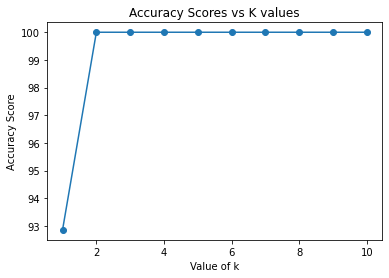

In [47]:
import matplotlib.pyplot as plt

# Assuming acc_scores is a list of accuracy scores for each fold
print(acc_scores)
for i in range (0, len(acc_scores)):
    acc_scores[i]=acc_scores[i]*100
k_values = [i for i in range(1, len(acc_scores)+1)]
print(k_values)

# Plotting the accuracy scores vs k values
plt.plot(k_values, acc_scores, marker='o')
plt.xlabel('Value of k')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores vs K values')
plt.show()